# Neural Network Classification with PyTorch
[Continued...]

In [29]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.0+cu121
cuda


## 8. Putting it all together with a Multi-Class Classification Problem
- Binary Classification: one thing or another (cat vs dog, spam vs not spam, fraud or not fraud)
- Multi-class classification: more than one thing or another (cat vs dog vs chicken)

### [Scikit-learn make_blobs datasets](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)

In [2]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2

# Create a toy multi-class dataset
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,   # give the clusters a little shake up
                            random_state = 42)

In [3]:
# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) # See docs: Better optimization when there are many multiple class indices

X_blob[:10], y_blob[:10]

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815],
         [-6.7941, -6.4772],
         [ 5.2102,  2.8890],
         [-5.5051, -6.3604],
         [-6.5438, -4.8339],
         [ 6.4496,  0.7478]]),
 tensor([3, 2, 2, 1, 1, 2, 1, 2, 2, 1]))

In [4]:
# Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = 42)

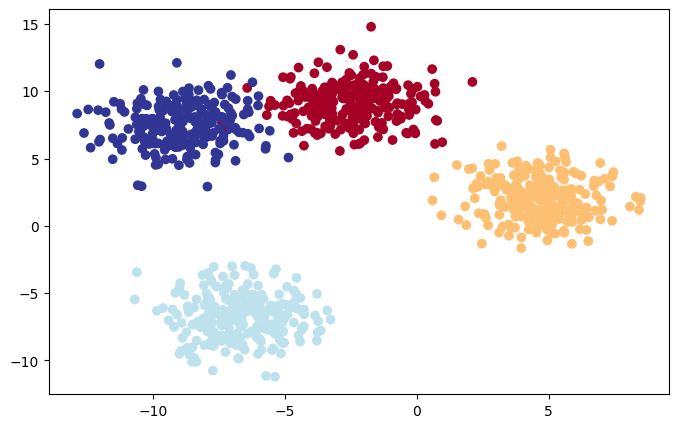

In [5]:
# Plot data
plt.figure(figsize=(8, 5))
plt.scatter(X_blob[:,0],
            X_blob[:,1],
            c = y_blob,
            cmap = plt.cm.RdYlBu);

### Building a Multi-class Classification Model

In [6]:
print(f'Input_features: {X_blob.shape}')

print(f'Unique output classes: {torch.unique(y_blob_train)}')
print(f'Output_features: {torch.unique(y_blob_train).shape}')

Input_features: torch.Size([1000, 2])
Unique output classes: tensor([0, 1, 2, 3])
Output_features: torch.Size([4])


In [7]:
class blobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Instance of blobModel class
blob_model = blobModel(input_features = 2,
                       output_features = 4,
                       hidden_units = 16).to(device)

blob_model

blobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [8]:
# Setting up loss functions and optimizers
loss_fn = nn.CrossEntropyLoss()     # if the labelling of dataset is imbalanced use weight(Tensor, optional) parameter
optimizer = torch.optim.Adam(params = blob_model.parameters(),
                              lr = 0.01)

In [9]:
next(blob_model.parameters()).device

device(type='cuda', index=0)

### Getting Prediction Probabilities for a Multi-class Classification Model

In [10]:
torch.manual_seed(42)

blob_model.eval()
with torch.inference_mode():
  y_logits = blob_model(X_blob_test.to(device))

y_logits[:10], y_blob_test[:10]

(tensor([[-0.3770,  0.5792,  0.3872,  0.2085],
         [-0.1445,  0.7125, -0.0899,  0.4033],
         [-0.6075,  1.7944,  0.4173,  1.6285],
         [-0.2266,  0.5136,  0.1336,  0.3800],
         [-0.2033,  0.4364,  0.6450,  0.1611],
         [-0.1906,  0.8536, -0.1414,  0.4552],
         [-0.6070,  1.7626,  0.3873,  1.6147],
         [-0.1078,  0.4265,  0.5153,  0.3325],
         [-0.7394,  2.0293,  0.4504,  1.7474],
         [-0.1299,  0.4215,  0.5446,  0.2672]], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]))

In [11]:
# Conversion of models raw logits outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim = 1)
y_pred_probs[:5]

tensor([[0.1325, 0.3448, 0.2846, 0.2380],
        [0.1628, 0.3836, 0.1720, 0.2816],
        [0.0413, 0.4566, 0.1152, 0.3868],
        [0.1571, 0.3294, 0.2253, 0.2882],
        [0.1499, 0.2842, 0.3501, 0.2158]], device='cuda:0')

In [12]:
# Conversion of model prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim = 1)
y_preds[:40], y_blob_test[:40]

(tensor([1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1,
         1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
         2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2]))

In [13]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

### Train/Test Loop

In [14]:
torch.manual_seed(42)

epochs = 100

# Tracking
epoch_count = []
loss_values = []
test_loss_values = []
train_acc_values = []
test_acc_values = []

# Placing data on CUDA
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Train
for epoch in range(epochs):
  blob_model.train()
  y_logits = blob_model(X_blob_train)
  y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)
  # print(y_blob_train.dtype, y_logits.dtype)
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train, y_pred = y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Test
  blob_model.eval()
  with torch.inference_mode():
    test_logits = blob_model(X_blob_test)
    test_preds = torch.softmax(test_logits, dim = 1).argmax(dim = 1)
    # print(test_logits.shape, y_blob_test.shape)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test,
                           y_pred = test_preds)

  if epoch % 10 == 0 or epoch == epochs - 1:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    train_acc_values.append(acc)
    test_acc_values.append(test_acc)
    print(f'Epoch: {epoch} ---- Train Loss: {loss:.4f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}')

Epoch: 0 ---- Train Loss: 1.5660 | Acc: 26.00% | Test Loss: 1.3476 | Test Acc: 41.50
Epoch: 10 ---- Train Loss: 0.2909 | Acc: 97.75% | Test Loss: 0.2292 | Test Acc: 98.50
Epoch: 20 ---- Train Loss: 0.0499 | Acc: 99.12% | Test Loss: 0.0394 | Test Acc: 99.50
Epoch: 30 ---- Train Loss: 0.0284 | Acc: 99.12% | Test Loss: 0.0192 | Test Acc: 99.50
Epoch: 40 ---- Train Loss: 0.0263 | Acc: 99.12% | Test Loss: 0.0144 | Test Acc: 99.50
Epoch: 50 ---- Train Loss: 0.0253 | Acc: 99.12% | Test Loss: 0.0128 | Test Acc: 99.50
Epoch: 60 ---- Train Loss: 0.0242 | Acc: 99.25% | Test Loss: 0.0124 | Test Acc: 99.50
Epoch: 70 ---- Train Loss: 0.0234 | Acc: 99.25% | Test Loss: 0.0124 | Test Acc: 99.50
Epoch: 80 ---- Train Loss: 0.0228 | Acc: 99.38% | Test Loss: 0.0122 | Test Acc: 99.50
Epoch: 90 ---- Train Loss: 0.0225 | Acc: 99.38% | Test Loss: 0.0118 | Test Acc: 99.50
Epoch: 99 ---- Train Loss: 0.0221 | Acc: 99.38% | Test Loss: 0.0114 | Test Acc: 99.50


## Loss Curves and Accuracy Curves

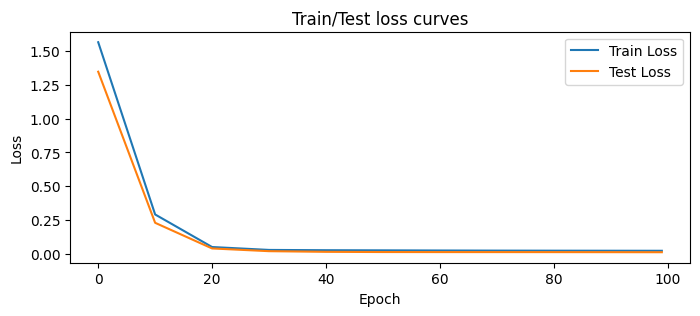

In [32]:
# Plot loss curves
plt.figure(figsize=(8,3))
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test Loss")
plt.title("Train/Test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend();

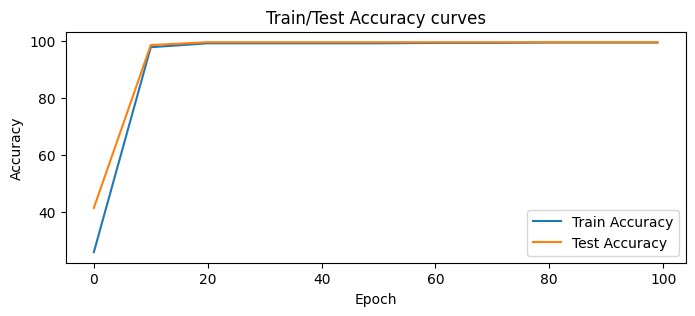

In [33]:
# Plot accuracy curves
plt.figure(figsize=(8,3))
plt.plot(epoch_count, np.array(torch.tensor(train_acc_values).numpy()), label="Train Accuracy")
plt.plot(epoch_count, np.array(torch.tensor(test_acc_values).numpy()), label="Test Accuracy")
plt.title("Train/Test Accuracy curves")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend();

### Making and Evaluating Predictions with a PyTorch Multi-Class Model

In [17]:
blob_model.eval()
with torch.inference_mode():
  y_logits = blob_model(X_blob_test)

y_logits[:10]

tensor([[ -5.3114,   8.6942,  -7.2347, -10.5196],
        [ -0.1752,  -7.6151,  -3.7123,   6.9117],
        [-10.8524,   0.1636,  11.8042,  -0.1714],
        [ -5.2704,   7.2523,  -4.7646,  -7.7836],
        [  6.1471,  -2.4428,  -9.3941,  -5.9058],
        [ -0.7478,  -9.2646,  -3.8878,   8.9476],
        [-10.4190,   0.5157,  10.6857,  -0.4209],
        [  5.8501,  -3.5187,  -8.6640,  -3.4834],
        [-12.8450,  -0.4965,  14.5880,   0.4706],
        [  5.9184,  -3.0401,  -8.6427,  -4.3784]], device='cuda:0')

In [18]:
# Transform logits -> Prediction probbailities
y_pred_probs = torch.softmax(y_logits, dim = 1)
y_pred_probs[:10]

tensor([[8.2688e-07, 1.0000e+00, 1.2083e-07, 4.5242e-09],
        [8.3531e-04, 4.9061e-07, 2.4304e-05, 9.9914e-01],
        [1.4466e-10, 8.8014e-06, 9.9998e-01, 6.2957e-06],
        [3.6429e-06, 9.9999e-01, 6.0411e-06, 2.9510e-07],
        [9.9981e-01, 1.8594e-04, 1.7801e-07, 5.8265e-06],
        [6.1561e-05, 1.2317e-08, 2.6644e-06, 9.9994e-01],
        [6.8283e-10, 3.8300e-05, 9.9995e-01, 1.5012e-05],
        [9.9983e-01, 8.5333e-05, 4.9724e-07, 8.8396e-05],
        [1.2190e-12, 2.8112e-07, 1.0000e+00, 7.3942e-07],
        [9.9984e-01, 1.2862e-04, 4.7441e-07, 3.3737e-05]], device='cuda:0')

In [22]:
# Prediction probabilities -> Pred labels
y_preds = torch.argmax(y_pred_probs, dim = 1)
y_preds[:20], y_blob_test[:20]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3],
        device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3],
        device='cuda:0'))

### Importing **`helper_function.py`** for `plot_decision_boundary()`

In [23]:
import requests
from pathlib import Path

# Download helper function from opensource scripts files
if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists, skipping download')
else:
  print('Downloading helper_function.py')
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)
  print('Download complete')

Download complete


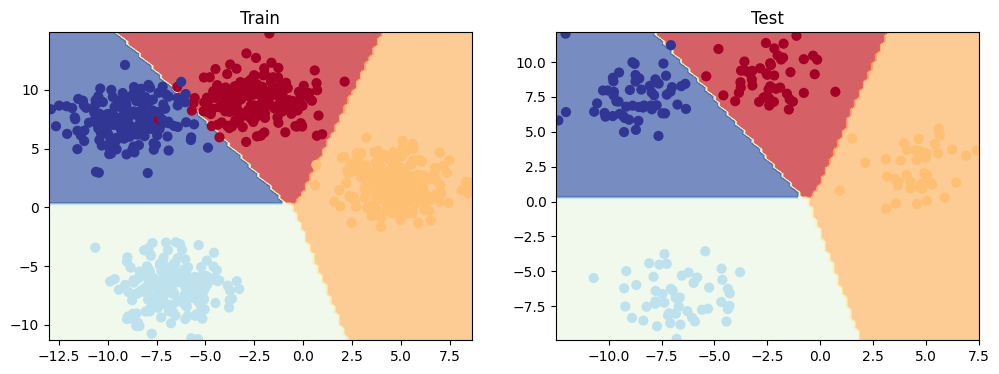

In [35]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(blob_model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(blob_model, X_blob_test, y_blob_test)

## 9. A few more Classification Metrics to Evaluate Classification Model

| Metric Name            | Definition                                                                                                                                                           | Code                                           |
|------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------|
| Accuracy               | Out of 100 predictions, how many does your model get correct? E.g., 95% accuracy means it gets 95/100 predictions correct.                                            | `torchmetrics.Accuracy()` or `sklearn.metrics.accuracy_score()`  |
| Precision              | Proportion of true positives over the total number of samples. Higher precision leads to fewer false positives (model predicts 1 when it should've been 0).         | `torchmetrics.Precision()` or `sklearn.metrics.precision_score()`  |
| Recall                 | Proportion of true positives over the total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to fewer false negatives. | `torchmetrics.Recall()` or `sklearn.metrics.recall_score()`  |
| F1-score               | Combines precision and recall into one metric. 1 is best, 0 is worst.                                                                                                | `torchmetrics.F1Score()` or `sklearn.metrics.f1_score()`  |
| Confusion Matrix       | Compares the predicted values with the true values in a tabular way. If 100% correct, all values in the matrix will be top left to bottom right (diagonal line).        | `torchmetrics.ConfusionMatrix` or `sklearn.metrics.plot_confusion_matrix()`  |
| Classification Report  | Collection of some of the main classification metrics such as precision, recall, and F1-score.                                                                  | `sklearn.metrics.classification_report()`  |

### [PyTorch Metrics](https://lightning.ai/docs/torchmetrics/stable/)

In [36]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 8.2 MB/s eta 0:00:00


In [39]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

### When to use Accuracy, precision and recall metrics?
- Use *Accuracy Metrics* when class labels are balanced
- USe *Precision or Recall Metricses* when class labels are imbalanced (Eg: sets of 1000 class_1 labels data and 10 class_0 labels data)